In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
train = pd.read_csv('/Users/chen-tze/Desktop/titanic/train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Preprocessing

* Extract Prefix from Name


Prefix can help us check a person's age and marriage. For example, "Mrs." represent that this lady is married, "Master" is the prefix for young boy. These important messages are hidden under the variable 'Name'.

We can find that all the data in "Name" follow the format below:

| Last Name | Prefix | First Name |
| --- | --- | --- |
| Braund | Mr. | Harris|

In [3]:
# seperate Last Name, Prefix, and First Name
Name = train['Name']
last = []
rest = []
for i in range(len(Name)):
    l = Name[i].split(',')[0]
    last.append(l)
    r = Name[i].split(',')[1]
    rest.append(r)

prefix = []
first = []
for i in range(len(Name)):
    f = rest[i].split('.')[1]
    first.append(f)
    p = rest[i].split('.')[0]
    prefix.append(p)

train['Prefix'] = prefix
train['Last Name'] = last
train['First Name'] = first
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Prefix,Last Name,First Name
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,Owen Harris
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,John Bradley (Florence Briggs Thayer)
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen,Laina
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,Jacques Heath (Lily May Peel)
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,William Henry


* Missing Values Imputation

In [4]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Prefix           0
Last Name        0
First Name       0
dtype: int64

In [5]:
# Distribution of 'Embarked'
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [6]:
# Distribution of 'Age'
train['Age'].fillna('NA', inplace = True)
pd.crosstab(train['Age'], train['Prefix']).iloc[-1, :]

Prefix
 Capt              0
 Col               0
 Don               0
 Dr                1
 Jonkheer          0
 Lady              0
 Major             0
 Master            4
 Miss             36
 Mlle              0
 Mme               0
 Mr              119
 Mrs              17
 Ms                0
 Rev               0
 Sir               0
 the Countess      0
Name: NA, dtype: int64

I would drop "Cabin" because around three of four values in the variable are missing. 

"Embarked" is a catigorical variable with three outcomes (S, C, Q) and I used mode to fill the missing values.

In [7]:
train['Embarked'].fillna('S', inplace = True)


Next, I filled 'Age' by following methods:

Prefix | Imputation | Category
--- | --- | ---
Master | Mean age of other Master | Young boys
Miss with Parch $\neq$ 0 | Mean age of other Miss with Parch $\neq$ 0 | Young girls
Miss with Parch = 0 | Mean age of the other Miss  | Young lady
Mrs | Mean age of other Mrs | Adult female
Others | Mean age of other Mr | Adult male

In [8]:
# 'Age' Imputation
nomiss = train[train['Age'] != 'NA']
master_age = round(nomiss[nomiss['Prefix']==' Master'].Age.mean())
miss1_age = round(nomiss[(nomiss['Prefix']==' Miss') & (nomiss['Parch']!=0)].Age.mean())
miss2_age = round(nomiss[(nomiss['Prefix']==' Miss') & (nomiss['Parch']==0)].Age.mean())
mrs_age = round(nomiss[nomiss['Prefix']==' Mrs'].Age.mean())
mr_age = round(nomiss[(nomiss['Prefix']!=' Master') & (nomiss['Sex']=='male')].Age.mean())

for i in range(train.shape[0]):
    if (train['Age'][i] == 'NA'):
        if (train['Prefix'][i]==' Master'):
            train['Age'][i] = master_age
        elif ((train['Prefix'][i]==' Miss') & (train['Parch'][i]!=0)):
            train['Age'][i] = miss1_age
        elif ((train['Prefix'][i]==' Miss') & (train['Parch'][i]==0)):
            train['Age'][i] = miss2_age
        elif (train['Prefix'][i]==' Mrs'):
            train['Age'][i] = mrs_age
        else:
            train['Age'][i] = mr_age


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: Set

In [9]:
train.drop('Cabin', axis = 1, inplace = True)
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Prefix         0
Last Name      0
First Name     0
dtype: int64

In [10]:
# data cleaning funciton
def cleaning(df):
    Name = df['Name']
    last = []
    rest = []
    for i in range(len(Name)):
        l = Name[i].split(',')[0]
        last.append(l)
        r = Name[i].split(',')[1]
        rest.append(r)
    prefix = []
    first = []
    for i in range(len(Name)):
        f = rest[i].split('.')[1]
        first.append(f)
        p = rest[i].split('.')[0]
        prefix.append(p)

    df['Prefix'] = prefix
    df['Last Name'] = last
    df['First Name'] = first
    df['Embarked'].fillna('S', inplace = True)
    nomiss = train[train['Age'] != 'NA']
    master_age = round(nomiss[nomiss['Prefix']==' Master'].Age.mean())
    miss1_age = round(nomiss[(nomiss['Prefix']==' Miss') & (nomiss['Parch']!=0)].Age.mean())
    miss2_age = round(nomiss[(nomiss['Prefix']==' Miss') & (nomiss['Parch']==0)].Age.mean())
    mrs_age = round(nomiss[nomiss['Prefix']==' Mrs'].Age.mean())
    mr_age = round(nomiss[(nomiss['Prefix']!=' Master') & (nomiss['Sex']=='male')].Age.mean())
    df['Age'].fillna('NA', inplace = True)
    for i in range(df.shape[0]):
        if (df['Age'][i] == 'NA'):
            if (df['Prefix'][i]==' Master'):
                df['Age'][i] = master_age
            elif ((df['Prefix'][i]==' Miss') & (train['Parch'][i]!=0)):
                df['Age'][i] = miss1_age
            elif ((df['Prefix'][i]==' Miss') & (train['Parch'][i]==0)):
                df['Age'][i] = miss2_age
            elif (df['Prefix'][i]==' Mrs'):
                df['Age'][i] = mrs_age
            else:
                df['Age'][i] = mr_age
    test_clean = df.drop('Cabin', axis = 1)
    return(test_clean)

# Data Exploratory

When the accident happened, managers followed some criteria to select people to aboard the limited lifeboats. They had to make the decision very quickly since they had to race against time, and, therefore, we might not need that many variables. 

In the begining, I defined a new variable 'Family Size', which is the sum of 'Parch' and 'SibSp'.  

In [11]:
train['Family Size'] = train.SibSp + train.Parch

'PassengerId', 'Name', and 'Ticket' are different from each person, so there are no information to show in these variables. I checked the correlation between 'Survived' and other variables and got the following information:

In [12]:
train.drop(['Name', 'Ticket', 'Last Name', 'First Name'], axis = 1, inplace = True)

* Female have way higher survival probaility (74%) than male (19%).

It showed that women might have the priority to left and only a few men are allowed to board. That is, the decision criterion might be different between female and male, and we might need to ****seperate female and male into two groups** and **train different model** for each group.

In [13]:
pd.crosstab(train['Survived'], train['Sex'], normalize = 'columns')

Sex,female,male
Survived,,
0,0.257962,0.811092
1,0.742038,0.188908


In [14]:
# Seperate male and female
Male = train[train['Sex']=='male']
Male.reset_index(drop = True, inplace = True)
Female = train[train['Sex']=='female']
Female.reset_index(drop = True, inplace = True)

### Male

Most males were died in this accidnets, so my object is to figure out what made those men alive.

1. The following table showed that the survival probability of 'Master' is more than 50%

In [15]:
pd.crosstab(Male['Survived'], Male['Prefix'])

Prefix,Capt,Col,Don,Dr,Jonkheer,Major,Master,Mr,Rev,Sir
Survived,,,,,,,,,,
0,1,1,1,4,1,1,17,436,6,0
1,0,1,0,2,0,1,23,81,0,1


2. Interestingly, all the young boys in class 1 and class 2 survived.

In [16]:
Master = Male[Male['Prefix']==' Master']
pd.crosstab(Master['Survived'], Master['Pclass'], normalize = 'columns')

Pclass,1,2,3
Survived,,,
0,0.0,0.0,0.607143
1,1.0,1.0,0.392857


3. Only 1 person alive when the family size is greater than 3.

In [17]:
pd.crosstab(Male['Survived'], Male['Family Size'])

Family Size,0,1,2,3,4,5,6,7,10
Survived,,,,,,,,,
0,347,56,32,5,3,14,3,4,4
1,64,18,21,5,0,0,1,0,0


In [18]:
pd.crosstab(Male['Survived'], Male['Pclass'])

Pclass,1,2,3
Survived,,,
0,77,91,300
1,45,17,47


### Female

Oppsite to male, we have to figure out the reason why they were not selected.

1. Women in class 1 and class 2 had more than 90% survival probability. 

Obviously women in class 1 and class 2 had the priotiry to aboard lifeboats so I seperated felames into 'class 3' and 'class 1&2'.

In [19]:
f_c3 = Female[Female['Pclass'] == 3]
f_c12 = Female[Female['Pclass'] != 3]
pd.crosstab(Female['Survived'], Female['Pclass'], normalize = 'columns')

Pclass,1,2,3
Survived,,,
0,0.031915,0.078947,0.5
1,0.968085,0.921053,0.5


2. Most of victims embarked from port S.

In [20]:
pd.crosstab(f_c3['Survived'], f_c3['Embarked'])


Embarked,C,Q,S
Survived,,,
0,8,9,55
1,15,24,33


In [21]:
pd.crosstab(f_c12['Survived'], f_c12['Embarked'])

Embarked,C,Q,S
Survived,,,
0,1,0,8
1,49,3,109


In [22]:
pd.crosstab(f_c12['Survived'], f_c12['Family Size'])

Family Size,0,1,2,3,4,5
Survived,,,,,,
0,4,2,1,2,0,0
1,62,56,26,11,3,3


In [23]:
pd.crosstab(f_c3['Survived'], f_c3['Family Size'])

Family Size,0,1,2,3,4,5,6,7,10
Survived,,,,,,,,,
0,23,14,10,1,9,5,5,2,3
1,37,15,12,5,0,0,3,0,0


# Feature Seletction and Model Training

Frome the last step, I divided males and femals into two groups found that the major factors related to survival are different. Here I followed the result and build model for each group.

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

* **Male**

The key factors are 'Prefix', 'Pclass', and 'Family Size'.

In [25]:
# modify Prefix
Male['Master'] = Male['Age']
for i in range(Male.shape[0]):
    if (Male['Prefix'][i] ==' Master'):
        Male['Master'][i] = 1
    else:
        Male['Master'][i] = 0
# dummy
pc = pd.get_dummies(Male['Pclass'], drop_first=True)
xx_male = pd.concat([Male, pc], axis = 1)
# variable selection
x_male = xx_male[['Family Size','Master', 2, 3]]
y_male = xx_male[['Survived']].to_numpy()
# fit model
DT_male = DecisionTreeClassifier(criterion='entropy').fit(x_male, y_male.ravel())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj,

* Female

Since the survival probability of class 1 and class 2 is more than 90%, I just guess women in these classes were survived.

The major factors of survival in class 3 are 'Family Size', 'Fare', 'Child', and 'Embarked'.



In [26]:
# define young girl
Female['Child'] = Female['Prefix']
for i in range(Female.shape[0]):
    if (Female['Age'][i] <= 10):
        Female['Child'][i] = 1
    else:
        Female['Child'][i] = 0
# class 3
f3 = Female[Female['Pclass']==3]
f3.reset_index(drop=True, inplace = True)
# dummy
embark = pd.get_dummies(f3['Embarked'], drop_first=True)
ff3 = pd.concat([f3, embark], axis = 1)
# variable selection
x_female = ff3[['Family Size', 'Fare', 'Child', 'Q', 'S']]
y_female = ff3[['Survived']].to_numpy()
DT_female = KNeighborsClassifier(1).fit(x_female, y_female.ravel())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj,

I build the model by KNN with k = 1 (see the figure below).

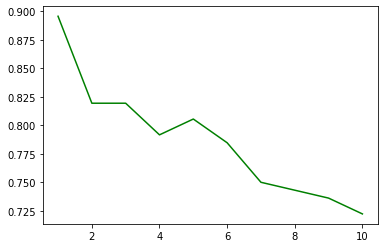

In [27]:
acc=np.zeros(10)
for n in range(1,11):
    knn = KNeighborsClassifier(n).fit(x_female, y_female.ravel())
    yhat = knn.predict(x_female)
    acc[n-1] = accuracy_score(y_female, yhat)
import matplotlib.pyplot as plt
plt.plot(range(1,11), acc, 'g')


In [28]:
# data seperation - male
def male(df):
    Male = df[df['Sex']=='male']
    Male.reset_index(drop = True, inplace = True)
    Male['Master'] = Male['Age']
    for i in range(Male.shape[0]):
        if (Male['Prefix'][i] ==' Master'):
            Male['Master'][i] = 1
        else:
            Male['Master'][i] = 0
    pc = pd.get_dummies(Male['Pclass'], drop_first=True)
    xx_male = pd.concat([Male, pc], axis = 1)
    return(xx_male)

In [29]:
# data seperation - female
def female(df):
    Female = df[df['Sex']=='female']
    Female.reset_index(drop = True, inplace = True)
    Female['Child'] = Female['Prefix']
    for i in range(Female.shape[0]):
        if (Female['Age'][i] <= 10):
            Female['Child'][i] = 1
        else:
            Female['Child'][i] = 0
    f3 = Female[Female['Pclass']==3]
    f3.reset_index(drop=True, inplace = True)
    embark = pd.get_dummies(f3['Embarked'], drop_first=True)
    ff3 = pd.concat([f3, embark], axis = 1)
    return(ff3)

# Evaluation

In [30]:
i=0
acc = []
while(i<1000):
    x_train, x_test, y_train, y_test = train_test_split(x_male,y_male, test_size=0.4)
    
    #DT = DecisionTreeClassifier(criterion='entropy').fit(x_train, y_train)
    DT = DecisionTreeClassifier(criterion='entropy').fit(x_train, y_train)
    yhat = DT.predict(x_test)    
    score = accuracy_score(y_test, yhat)
    acc.append(score)
    i=i+1
    
avg_acc = sum(acc)/len(acc)

print('The accuracy of Decision Tree mode in Male is', avg_acc)

The accuracy of Decision Tree mode in Male is 0.8430043290043285


In [31]:
i=0
acc = []
while(i<1000):
    x_train, x_test, y_train, y_test = train_test_split(x_female,y_female, test_size=0.1)
    DT = KNeighborsClassifier(1).fit(x_train, y_train.ravel())
    #DT = DecisionTreeClassifier(criterion='entropy').fit(x_train, y_train)
    yhat = DT.predict(x_test)    
    score = accuracy_score(y_test, yhat)
    acc.append(score)
    i=i+1

print('The accuracy of model in Female is', sum(acc)/len(acc))

The accuracy of model in Female is 0.6492666666666701


In [32]:
# male
yhat_male = DT_male.predict(x_male)
#accuracy_score(y_male, yhat_male)
out_male = pd.DataFrame({'Yhat': yhat_male})
result_male = pd.concat([xx_male, out_male], axis = 1)
# female in c3
yhat_f3 = DT_female.predict(x_female)
out_female = pd.DataFrame({'Yhat': yhat_f3})
result_female = pd.concat([f3, out_female], axis = 1)
# female in c1, c2
f12 = Female[Female['Pclass']!=3]
f12['Yhat'] = 1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [33]:
result_all = pd.concat([result_male, result_female, f12], axis = 0)
accuracy_score(result_all['Survived'], result_all['Yhat'])

0.8765432098765432

# Test result

In [34]:
test = pd.read_csv('/Users/chen-tze/Desktop/titanic/test.csv')
test['Family Size'] = test.SibSp + test.Parch
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Family Size      0
dtype: int64

In [35]:
fare_mean = test['Fare'].mean()
test['Fare'].fillna(fare_mean, inplace = True)
test_clean = cleaning(test)
test_clean.isnull().sum()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A valu

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Family Size    0
Prefix         0
Last Name      0
First Name     0
dtype: int64

In [36]:
test_male = male(test_clean)
test_f3 = female(test_clean) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [37]:
# prediction - c12
test_f12 = test_clean[(test_clean['Sex']=='female')&(test_clean['Pclass']!=3)]
test_f12['Survived'] = 1
# prediction - male
fit_male = test_male[['Family Size','Master', 2, 3]]
test_male['Survived'] = DT_male.predict(fit_male)
# prediction - c3
fit_f3 = test_f3[['Family Size', 'Fare', 'Child', 'Q', 'S']]
test_f3['Survived'] = DT_female.predict(fit_f3)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
test_result = pd.concat([test_male, test_f12, test_f3], axis = 0)


In [39]:
out = test_result[['PassengerId', 'Survived']]
out.sort_values(by = 'PassengerId', inplace = True)
out.reset_index(drop = True, inplace = True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
out.to_csv('outcome.csv',index=False)
out

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
